In [2]:
# Created on jan 2025
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012692

# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#saving results
import os


# Empirical data

In [3]:
import os

data_dir = './' # data repo
res_dir = './results_1104_trial/' # results
os.makedirs(res_dir, exist_ok=True)
graph_format = 'png' # graph formatting


# data and model parameters
n_sub = 48
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90

In [4]:
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')

In [5]:
condition_0 = TS_CTR[:, 0:68, :] 
condition_0.shape 

(116, 68, 152)

In [6]:

# Example input array of shape (180, 718, 36)
#original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array_original = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array_original.shape)

n_sub = 47

New array shape: (48, 68, 152, 2)


In [7]:
# Define indices to remove
indices_to_remove = {0: 19, 1: 11}

# Use list comprehension to filter out the indices for each condition
new_array_old = np.stack([
    new_array_original[np.arange(48) != indices_to_remove[0], :, :, 0],  # Remove index 19 for condition 0
    new_array_original[np.arange(48) != indices_to_remove[1], :, :, 1]   # Remove index 11 for condition 1
], axis=-1)

print(new_array_old.shape)  # Should be (47, 68, 152, 2)


(47, 68, 152, 2)


In [28]:
import numpy as np

# Assuming new_array is your original array with shape (47, 68, 152, 2)
regions_to_remove = [0, 4, 7, 13, 17, 31, 38, 39, 40, 45, 48, 64]  #12 elements

# Use np.delete to remove the specified regions along axis 1
new_array = np.delete(new_array_old, regions_to_remove, axis=1)

# Now new_array_filtered should have shape (47, 66, 152, 2)
print(new_array.shape)


(47, 56, 152, 2)


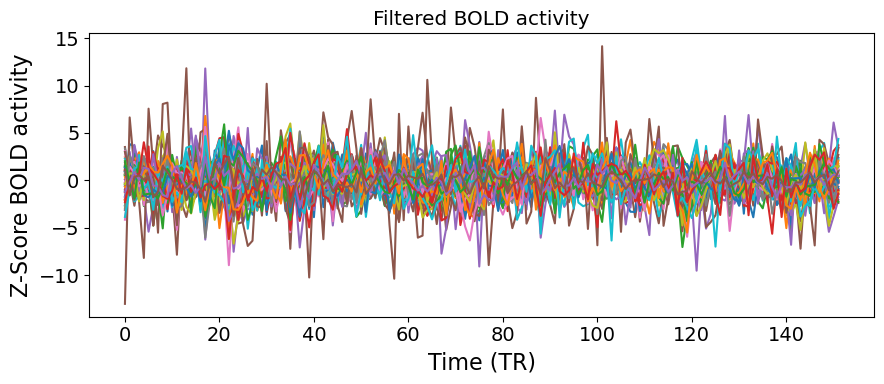

In [29]:
#All data plotted are stored in new_array
plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

Text(0.5, 1.0, 'FC0')

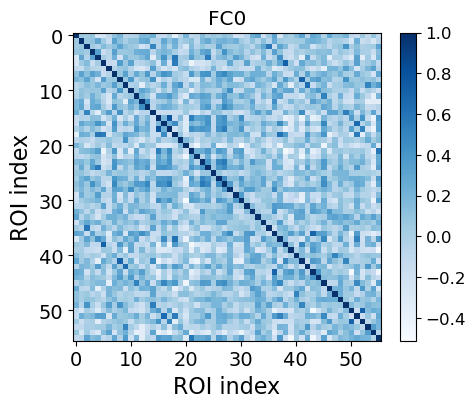

In [30]:
FC0 = np.corrcoef(new_array[1,:,:,1]) 
FC1 = FC0/np.max(FC0)
plt.figure(figsize=(5,4))
plt.imshow(FC1, cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("FC0")

# MOU fitting to fMRI data

11 1
19 0
46 1

In [12]:
lim_FC = np.full((48, 2), 0.1)

'''
#outliers
lim_FC[11, 1] = 0.05
lim_FC[19, 0] = 0.05
'''
#good changes
lim_FC[23, 1] = 0.2
lim_FC[18, 1] = 0.2
lim_FC[45, 0] = 0.2
lim_FC[11, 0] = 0.3
lim_FC[45, 0] = 0.3
lim_FC[45, 1] = 0.2

'''
EPR is high: [15, 1]
EPR is high: [24, 1]
'''
lim_FC[15, 1] = 0.1
lim_FC[24, 1] = 0.1

## Create Functional Mask

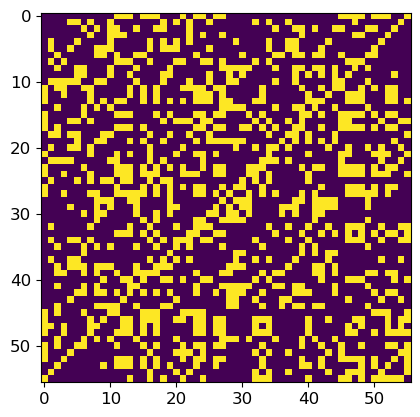

In [32]:

#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

n_sub=47
n_cond=2
N=56
# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_ECF = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_ECF[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i,i] = False # no self connection
            mask_ECF[i,N-1-i] = True # additional interhemispherical connections

plt.imshow(mask_ECF)


In [34]:
#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

n_sub=47
n_cond=2
N=56
# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

# create topological mask for AAL90
# Indices to remove
regions_to_remove = [0, 4, 7, 13, 17, 31, 38, 39, 40, 45, 48, 64]
SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
# Remove both rows and columns
SC_filtered = np.delete(np.delete(SC, regions_to_remove, axis=0), regions_to_remove, axis=1)
lim_SC = 0.9 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC_filtered>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = False # no self connection
    mask_ECS[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)

# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_ECF = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_ECF[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_ECF[i,i] = False # no self connection
            mask_ECF[i,N-1-i] = True # additional interhemispherical connections
        
        mask_EC = np.logical_or(mask_ECS, mask_ECF).astype(int)
 
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_ECF, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)



network size: 56
EC density: 0.02077922077922078
sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 118, 'distance': np.float64(0.7379267434540793), 'correlation': np.float64(0.7534290563076209), 'distance history': array([0.8977189 , 0.89560804, 0.89352009, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.44183711, 0.44722655, 0.45254265, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7116044570933645), 'distFC1': np.float64(0.7643922106036134)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 80, 'distance': np.float64(0.7560658092476514), 'correlation': np.float64(0.7161490086610869), 'distance history': array([0.87958004, 0.87724905, 0.87498352, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.43968228, 0.44789847, 0.45593902, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.6696148235487551), 'distFC1': np.float64(0.8425401490659847)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations'

Check that each participant has a goodness of fit higher then 0.55

In [35]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if fit_mod[i_sub,i_cond]< 0.55:
            print(i_sub, i_cond)

In [36]:
#%% save results
np.save(os.path.join(res_dir, f'J_mod_try.npy'), J_mod)
np.save(os.path.join(res_dir, f'Sigma_mod_try.npy'), Sigma_mod)
np.save(os.path.join(res_dir, f'FC0_mod_try.npy'), FC0_mod)

np.save(os.path.join(res_dir, f'err_mod_try.npy'), err_mod)
np.save(os.path.join(res_dir, f'fit_mod_try.npy'), fit_mod)

np.save(os.path.join(res_dir, f'var_BOLD_try.npy'), var_BOLD)


## Test goodness of fit

/tmp/ipykernel_29706/1680162601.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_29706/1680162601.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_29706/1680162601.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_29706/1680162601.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


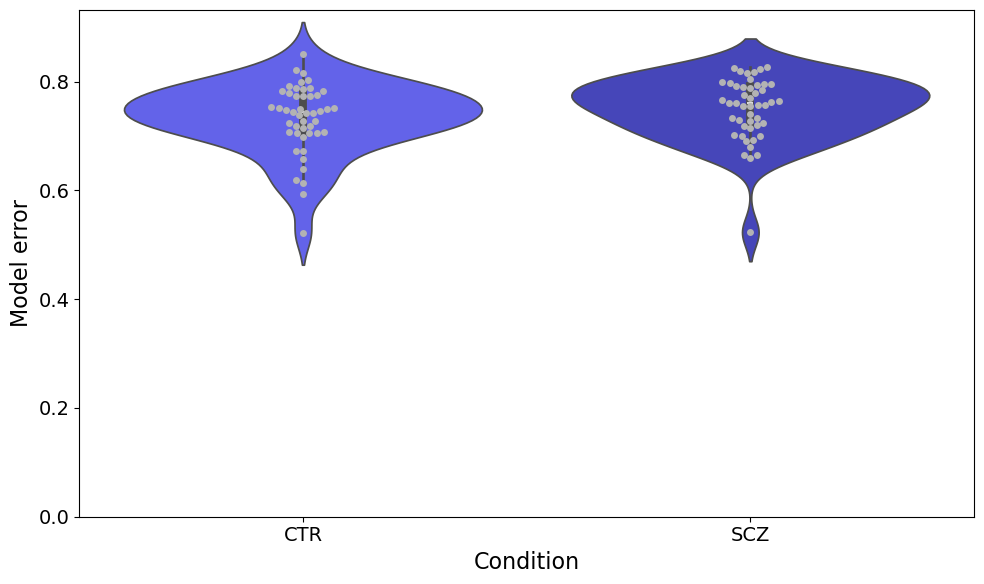

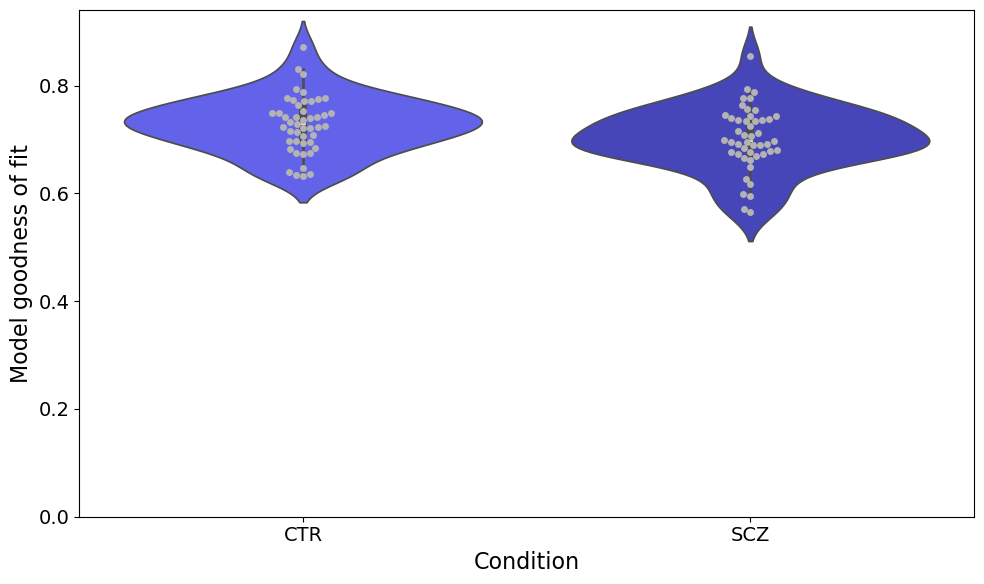

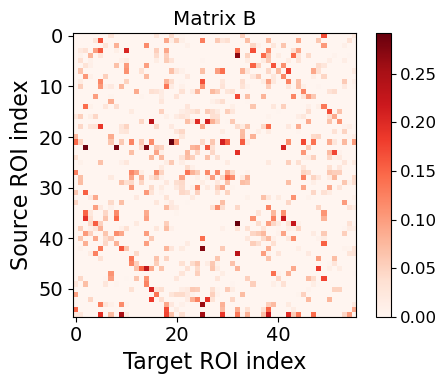

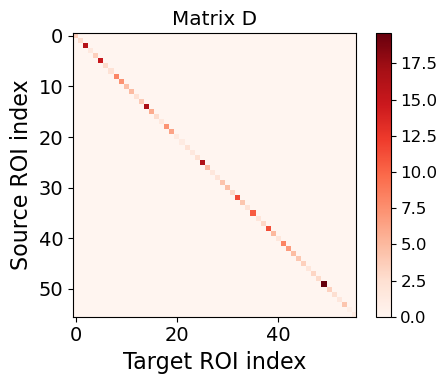

In [37]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)
# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_fit_error_try.eps'), format='eps')

# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)


# Create the figure
plt.figure(figsize=(10, 6))
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_goodness_fit_try.eps'), format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix B')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example0_EC_try.eps'), format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Matrix D')
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example_EC_try.eps'), format='eps')

# 


In [38]:
# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)



# Calculate Entropy Production of the fitted MOU

In [39]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

def is_antisymmetric(A, tol=1e-8):
    if A.shape[0] != A.shape[1]:
        return False  # Must be square
    return np.allclose(A.T, -A, atol=tol)

Q_antisym = np.zeros([n_sub, n_cond], dtype=bool)


for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            Q_antisym[i_sub, i_cond] = is_antisymmetric(Q)
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
                '''
                it was just to check if I was working with all real matrices and of course I am:
                print(np.iscomplexobj(B))
                print(np.iscomplexobj(D))
                print(np.iscomplexobj(S))
                '''

            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))  #-tr(S^(-1)*Q*D^(-1)*Q)
            EPR[i_sub,i_cond] = entropy_prod_rate


        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(os.path.join(res_dir, f'EPR_try.npy'),EPR)



should be close to zero: 3.720678279361955e-14
should be close to zero: 5.3290705182007514e-14
should be close to zero: 9.947598300641403e-14
should be close to zero: 2.4158453015843406e-13
should be close to zero: 2.2737367544323206e-13
should be close to zero: 4.7351012000262926e-14
should be close to zero: 5.684341886080802e-14
should be close to zero: 9.947598300641403e-14
should be close to zero: 7.105427357601002e-14
should be close to zero: 6.750155989720952e-14
should be close to zero: 1.8474111129762605e-13
should be close to zero: 1.2789769243681803e-13
should be close to zero: 5.115907697472721e-13
should be close to zero: 8.856804178947186e-14
should be close to zero: 1.4210854715202004e-13
should be close to zero: 6.394884621840902e-14
should be close to zero: 2.8421709430404007e-13
should be close to zero: 2.2737367544323206e-13
should be close to zero: 4.973799150320701e-14
should be close to zero: 2.4158453015843406e-13
should be close to zero: 1.4921397450962104e-13
sh

Check if there are some strange high EPR values

In [40]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if abs(EPR[i_sub,i_cond]) > 10: print(f"EPR is high: {[i_sub, i_cond]}")

/tmp/ipykernel_29706/3841950413.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_29706/3841950413.py:19: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


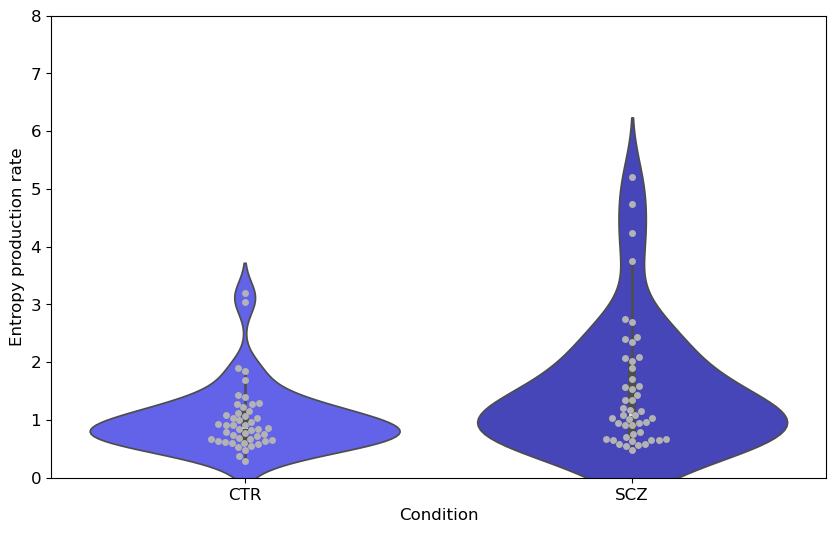

In [41]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

# real data
# Create the figure
plt.figure(figsize=(10, 6))
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=8)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(os.path.join(res_dir, f'entropy_prod_rate_try.eps'), format='eps')

## Statistical significance test 


Statistical Test Results:
Mann-Whitney U test statistic: 780.00
p-value: 0.014
statistically significant difference between the distributions of the two groups


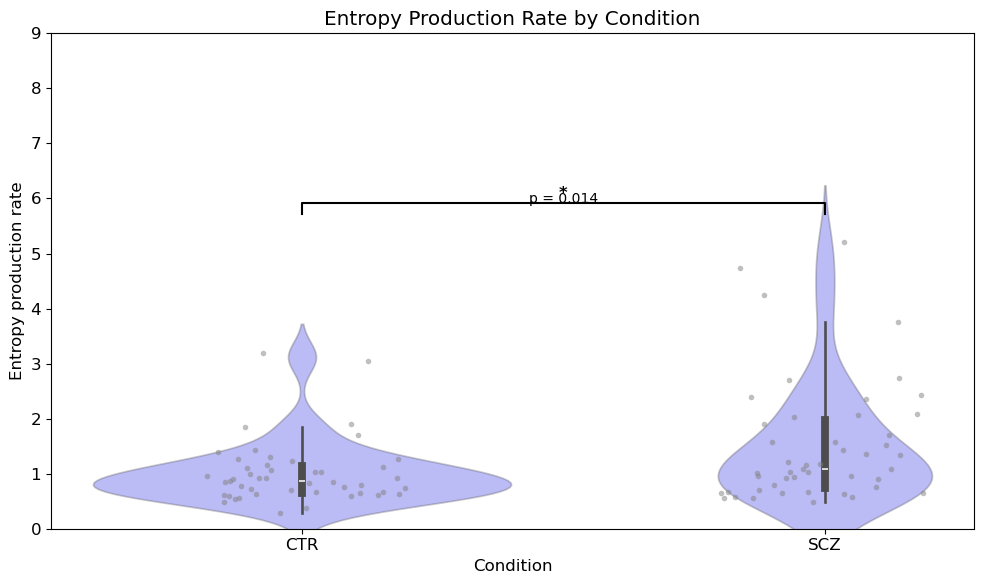

In [42]:
#trial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*47 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['Entropy_production_rate']
scz_data = data[data['Condition'] == 'SCZ']['Entropy_production_rate']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(10, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def improved_stat_annotation(p_value):
    # Define significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'  # Not significant
    
    # Get the highest data value dynamically
    y_max = data['Entropy_production_rate'].max()
    bar_height = y_max + 0.5  # Adjusted for better placement

    # Plot significance bar
    x1, x2 = 0, 1  # X positions for CTR and SCZ
    plt.plot([x1, x1, x2, x2], 
             [bar_height, bar_height + 0.2, bar_height + 0.2, bar_height],
             'k-', linewidth=1.5)
    
    # Add significance stars
    plt.text((x1 + x2) * 0.5, bar_height + 0.25, star_string,
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Add p-value annotation separately
    plt.text((x1 + x2) * 0.5, bar_height + 0.15, f'p = {p_value:.3f}',
             ha='center', va='bottom', fontsize=10)

# Add the significance annotation
improved_stat_annotation(p_value)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
#plt.grid(True, alpha=0.3)
plt.tight_layout()

'''
# Adjust layout
plt.show()
'''

plt.savefig(os.path.join(res_dir, 'EPR_stat_test.jpg'), format='jpg', dpi=300)

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")